In [ ]:
# Run this command to install sklearn:
# Instalar sklearn:
#!pip install sklearn

# Run this command to install seaborn:
# Instalar seaborn:
#!pip install seaborn

# Run this command to install pyspark:
# Instalar pyspark:
#!pip install pyspark[sql]
#!pip install pyspark[pandas_on_spark]

In [4]:
# Necessary imports
# Imports necessarios
from sklearn import datasets
import pandas as pd
import numpy as np
import seaborn as sns
import pyspark.sql
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [ ]:
# Load the data from sklearn dataset
# Carregar a data inicial do sklearn dataset
boston_initial_data = datasets.load_boston()

# Print the description of the data
# Print a descricao da data
print(boston_initial_data.DESCR)

In [ ]:
# Print the feature names (possible columns in the future)
# Print as feature names (possivelmente serao colunas depois)
print(boston_initial_data.feature_names)
# We can see from the print statement that the 'MEDV' col is missing
# Podemos ver que a coluna 'MEDV' nao esta nos feature names

# Print all keys of the dataset for further exploration
# Print todas as keys do dataset para explorar a data
print(boston_initial_data.keys())

# !!! The 'target' key corresponds to the missing MEDV col !!!
# !!! A key 'target' corresponde a coluna MEDV !!!

In [7]:
# Create a pandas df with the dataset
# Criar um pandas df com o dataset original
boston_df = pd.DataFrame(boston_initial_data.data, columns=boston_initial_data.feature_names)

# Add the target col as MEDV
# Adicionar a coluna target como MEDV
boston_df['MEDV'] = boston_initial_data.target

In [ ]:
# Check the first 5 rows from the df
# Verificar as primeiras filas do df
boston_df.head()

# !!! DATA  OK !!!

In [ ]:
# Second check - null values
# Segunda verificacao - valores nulos
boston_df.isnull().sum()

# !!! DATA OK !!!

Now that we've checked that the data OK, we can explore it.

Agora que verificamos que a data esta OK, podemos comecar a explorar o dataset.

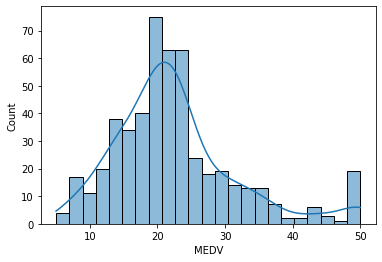

In [10]:
# Using seaborn histplot (kde=true gives us the curve)
# Usando seaborn histplot (kde=true inclui a curva no grafico)
sns.histplot(boston_df['MEDV'], kde=True)

# We can see that there is a normal distribution with outliers
# Podemos ver que existe uma distribuicao normal com valores atipicos

Since we have so many possible variables for our linear regression model, we should create a correlation matrix to check which variable has the highest positive correlation and lowest negative correlation with out target (MEDV). We will create three models, two will use the highest and lowest correlation variables, and the other model will use the VectorAssembler transformer from PySpark to combine all variables into one, and use this single merged variable.

Como temos tantas variaveis possiveis para o modelo de regressao linear, 
podemos criar uma matriz de correlacao para verificar as variaveis e encontrar
a variavel com a maior correlacao positiva e menor correlacao negativa em relacao ao target (MEDV). Vamos criar tres modelos diferentes; dois serao com as variaveis com maior e menor correlacao, e o terceiro modelo usara a funcao VectorAssembler do PySpark para combinar todas as variaveis em uma so, e usar essa variavel combinada no modelo.

In [ ]:
# Create a correlation matrix
# Matriz de correlacao
correlation = boston_df.corr()

# Print the correlations between all vars and MEDV (sorted)
# Print as correlacoes entre as variaveis e MEDV (em ordem)
print(correlation['MEDV'].sort_values(ascending=False))

# !!! HIGHEST - RM /// LOWEST - LSTAT !!!
# !!! MAIOR - RM /// MENOR - LSTAT !!!

In [12]:
# Now we will start using PySpark. We need to create a SparkSession
# Agora vamos comecar a usar pyspark. Precisamos criar uma SparkSession
spark = pyspark.sql.SparkSession \
    .builder.master('local[2]') \
    .appName("Linear Regression Model YHub") \
    .getOrCreate()

# SparkSession syntax: 
# master(local[x]) --> This is the master node, running locally with 2 cores (partitions)
# appname () --> Name of the sparksession app

In [ ]:
# Create a spark df for the boston df
# Criar uma spark df com a data do boston df
boston_spark_df = spark.createDataFrame(boston_df)
boston_spark_df.show(10)

In [ ]:
# Using the RM variable 
rm_boston_spark_df = boston_spark_df.select(['RM','MEDV'])
rm_boston_spark_df.show(truncate=False)

In [ ]:
# Using the LSTAT variable
lstat_boston_spark_df = boston_spark_df.select(['LSTAT','MEDV'])
lstat_boston_spark_df.show(truncate=False)

In [ ]:
# Using the VectorAssembler function to merge all columns together
# Usando a funcao VectorAssembler para combinar todas as variaveis
assembler = VectorAssembler(
    inputCols=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'],
    outputCol='FEATURES')

# Combining the new Features col to our df, then removing unecessary cols
# Combinando a nova coluna Features com a nossa df, e removendo as outras cols
vector_boston_spark_df = assembler.transform(boston_spark_df).select(['FEATURES','MEDV'])
vector_boston_spark_df.show(truncate=False)

In [33]:
def split_datasets(df, train, test):
  training_data, test_data = df.randomSplit([train,test])
  return training_data, test_data

In [35]:
# Split df into two; training and test data (75/25)
# Separar a df em dois; data de treino e teste (75/25)
vector_training_data, vector_test_data = split_datasets(vector_boston_spark_df,0.75,0.25)

rm_training_data, rm_test_data = split_datasets(rm_boston_spark_df,0.75,0.25)

lstat_training_data, lstat_test_data = split_datasets(lstat_boston_spark_df,0.75,0.25)

In [16]:
# Now we use the LinearRegression function (using MSE as loss function)
# Agora usamos LinearRegression, usando MSE como a loss function
model = LinearRegression(featuresCol = 'FEATURES', labelCol = 'MEDV')

# Fit the training data into the lin regression model
# Fazemos o ajuste da data no modelo de regressao linear
model = model.fit(training_data_spark)

In [25]:
# Create a LinearRegressionSummary object using the evaluate method
# Criar um objeto LinearRegressionSummary usando o metodo "evaluate"
test_predictions = model.evaluate(test_data_spark)
test_predictions.predictions.show(10)

+--------------------+----+------------------+
|            FEATURES|MEDV|        prediction|
+--------------------+----+------------------+
|[0.00632,18.0,2.3...|24.0| 30.44614630832068|
|[0.01381,80.0,0.4...|50.0| 40.65512398945653|
|[0.01778,95.0,1.4...|32.9| 30.40784555252099|
|[0.01951,17.5,1.3...|33.0|22.547565591818174|
|[0.02009,95.0,2.6...|50.0| 42.98722138840401|
|[0.02875,28.0,15....|25.0|29.676694913898515|
|[0.03237,0.0,2.18...|33.4| 28.50390662590334|
|[0.03551,25.0,4.8...|22.9| 25.36904124473009|
|[0.03584,80.0,3.3...|23.5| 30.71084959504558|
|[0.03768,80.0,1.5...|34.6| 34.56559608228523|
+--------------------+----+------------------+
only showing top 10 rows



In [17]:
# Check the r-squared value of the model
# Verificando o valor do r ao quadrado do modelo
training_r2 = model.summary.r2
print(training_r2)

# Check the RMSE value of the model
# Verificando o valor do erro quadratico medio do modelo
training_rmse = model.summary.rootMeanSquaredError
print(training_rmse)

0.727957710821554
4.778122986328471


In [27]:
# Check the r-squared value of the model
# Verificando o valor do r ao quadrado do modelo
test_r2 = test_predictions.r2
print(test_r2)

# Check the r-squared value of the model
# Verificando o valor do r ao quadrado do modelo
test_rmse = test_predictions.rootMeanSquaredError
print(test_rmse)

0.7658813649544587
4.481510179179157


With this data, we see that we had a higher r-squared value on our test set compared to the r-squared value from the training set. We also see a decrease in the RMSE from the training to the test set. 

Com esse resultado, podemos ver que o valor do r ao quadrado aumenta quando usamos o test data em relacao ao training data. Tambem vemos uma diminuicao no valor do erro quadratico medio quando vamos da data de treino para a data de teste.